# Explained features by intensity quartiles

Get khipus using updated grid,
Add new list of fragments
- Collect features that are explained;
- and numbers of unique empCpds

Plot how they overlap by each incremental quartile of features.

The candidate fragments are based on frequent delta m/zs. 

Not using those from MS2 as the freq lists here should be more inclusive.

Will move the frequent lists and top ones into mass2chem and khipu packages.

In [1]:
import io
import sys
import json
import tqdm
import contextlib
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list

sys.path.insert(0, '..')
from mining import * 
from isf_helper import (extract_ms2_spectrum, 
                        get_comprehensive_stats_per_dataset, 
                        explain_a_dataset_by_mz_deltas, 
                        explain_a_dataset_byMS2)

VERSION = '1_3'
dir_fig_output = f'../fig_for_pub/{VERSION}/orbi/'
os.makedirs(dir_fig_output, exist_ok=True)

In [2]:
# Input data 

orbi_datasets = [x.rstrip() for x in open('selected_45_orbi_datasets.txt').readlines()]
pos_orbi_datasets = [x for x in orbi_datasets if 'pos' in x]
neg_orbi_datasets = [x for x in orbi_datasets if 'neg' in x]

# dict_tablefiles = {}
# for line in open('list_input_files.tsv').readlines():
#     a = line.rstrip().split('\t')
#     dict_tablefiles[a[0]] = a[1]

dict_rtwindow = {}
for line in open('elution_parameters_45studies_orbi.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

In [3]:
# pos ionization
isotope_search_patterns_pos = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

isotope_search_patterns_neg = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            (1.9958, '32S/34S', (0, 0.1)), # 4%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            (32.026215, 'CH3OH')
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), 
                            (67.987424, 'NaCOOH'),
                            (82.0030, 'NaCH2COOH'),
                            # (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'CH3OH'),
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

pos_candidate_fragments = '''14.0155	900	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
18.0104	885	18.010565	water	{'H': 2, 'O': 1}
2.0155	717	2.01565	± 2H, opening or forming of double bond	{'H': 2}
44.0261	652	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
28.0312	621	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
15.9948	479	15.9949	oxidation	{'O': 1}
17.0264	451	17.0265	addition of ammonia. Reaction: (+NH3)	{'N': 1, 'H': 3}
26.0155	440	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
27.9947	433	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
11.9999	426	12.0	methylation and reduction	{'C': 1}
42.0104	340	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	{'C': 2, 'H': 2, 'O': 1}
67.9872	325	67.987424	NaCOOH	{'C': 1, 'O': 2, 'Na': 1, 'H': 1}
13.9791	321	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
23.9998	317	24.0	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
16.0312	314	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
42.0468	314	42.04695	± C3H6, propylation	{'C': 3, 'H': 6}
46.0053	313	46.005305	formic acid adduct	{'C': 1, 'H': 2, 'O': 2}
88.0522	304	88.052429	butanoic acid	{'C': 4, 'H': 8, 'O': 2}
41.0263	295	41.026549	Acetonitrile	{'C': 2, 'H': 3, 'N': 1}
30.0468	267	30.04695	addition of C2H4 and hydrogenation. Reaction: (+C2H4) and (+H2)	{'C': 2, 'H': 6}
35.037	157	35.037114	addition of water and addition of ammonia. Reaction: (+H2O) and (+NH3)	{'H': 5, 'N': 1, 'O': 1}
'''
pos_candidate_fragments = [
    (float(x.split()[0]), x) for x in pos_candidate_fragments.splitlines()
]
pos_isf_candidate_fragments = [x[0] for x in pos_candidate_fragments]

In [31]:
pos_isf_candidate_fragments[:2]

[14.0155, 18.0104]

In [4]:
def assign_intensity_kilobins(list_features):
    '''
    Get features in intensity kilobins (1 kilobin = 1000 counts)
    
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns {} # to fit existing interface
    '''
    all_ = []
    for f in list_features:
        all_.append((float(f['peak_area']), f['id']))
    all_.sort(reverse=True)
    d = {}
    for ii in range(10):
        for f in all_[ii*1000: (ii+1)*1000]:
            d[f[1]] = ii
    for f in all_[10000:]:
        d[f[1]] = 100
    return d

def get_kList(khipus):
    neuList = []
    for k in khipus:
        if k['neutral_formula_mass']:
            neuList.append(
                {
                    'id': k['interim_id'],
                    'mz': k['neutral_formula_mass'],
                    'rtime': k['MS1_pseudo_Spectra'][0]['rtime'],
                }
            )
    return neuList

In [5]:
# get hmdb5
hmdb = '/Users/lish/li.proj/Resources/HMDB-5/parsed_hmdb_metabolites.tsv'    
# condense to formula and monoisotopic mass only
def get_list_from_hmdb_parsed(hmdb):
    hmdb = open(hmdb).readlines()                                                                                    
    header = hmdb[0].split('\t')   

    hdict = {}
    for line in hmdb[1:]:
        a = line.split('\t')
        if a[3].strip():
            hdict[a[0]] = a
            
    missing = []
    massDict_hmdb = {}
    h2 = [x.split('\t')[0] for x in hmdb[1:]]             
    for x in h2:  
        try: 
            a = hdict[x]  
            k = a[2]+ '_' + str(round(float(a[3]),6))  
            if k in massDict_hmdb:  
                massDict_hmdb[k].append( a[:2] )  
            else:  
                massDict_hmdb[k] = [a[:2]]  
        except KeyError: 
            missing.append(x) 
            
    len(massDict_hmdb), len(missing)

    list_hmdb5 = []
    for k in massDict_hmdb.keys():
        formula, nm = k.split('_')
        list_hmdb5.append({
            'id': formula,
            'mz': float(nm),
            'rtime': 0,
        })
    return list_hmdb5

list_hmdb5 = get_list_from_hmdb_parsed(hmdb)
len(list_hmdb5)

23245

In [6]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 50 minutes

tally_pos = []
quartile_matches_pos = {}
for study in tqdm.tqdm(pos_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'pos'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_pos, 
                                adduct_search_patterns=adduct_search_patterns_pos,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
    
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, pos_isf_candidate_fragments, 
            rt_stdev=dict_rtwindow[study]
            )
        
        unique_khipus = [k for k in list_khipus if k['interim_id'] not in explained_khipu_ids]
        high_conf_khipus = [k for k in unique_khipus if 
                            check_isopair_khipu(k)
                            ]
        hmdb_matched = mf.list_match_lcms_features(get_kList(high_conf_khipus), 
                        list_hmdb5, mz_ppm=5, rt_tolerance=1e20)

        dict_intensity_kilos = assign_intensity_kilobins(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        kilo_matches = [dict_intensity_kilos[x] for x in preannotated_feature_ids]

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'unique_khipus': len(unique_khipus),
                'high_conf_khipus': len(high_conf_khipus),
                'hmdb_matched_high_conf_khipus': len(hmdb_matched),
                # 
                'kilo_matches': kilo_matches,
            }
        tally_pos.append(cur_tally)
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        quartile_matches_pos[study] = {
            'M0': [dict_intensity_kilos[x] for x in M0_ids],
            'isotope': [dict_intensity_kilos[x] for x in isotope_ids],
            'fragment': [dict_intensity_kilos[x] for x in fragment_ids],
            'singletons': [dict_intensity_kilos[x] for x in singleton_ids],
        }
        round_id = '20251029_1'
        os.makedirs(f'output/{round_id}/pos/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output/{round_id}/pos/{study}/ecpds.json', 'w'))
        json.dump(cur_tally, open(f'output/{round_id}/pos/{study}/tally.json', 'w'))
        json.dump(quartile_matches_pos[study], open(f'output/{round_id}/pos/{study}/quartile_matches.json', 'w'))

100%|██████████| 22/22 [49:09<00:00, 134.05s/it] 


In [7]:
test0 = tally_pos[0]['kilo_matches']
tally_pos[0]['num_features'], [[len([x for x in test0 if x ==ii]) for ii in range(11)]]

(57875, [[931, 877, 823, 744, 724, 674, 696, 609, 542, 544, 0]])

In [8]:
[[len([x for x in tally_pos[15]['kilo_matches'] if x ==ii]) for ii in range(11)]]

[[913, 966, 935, 921, 897, 913, 855, 868, 862, 841, 0]]

In [9]:
for st, v in quartile_matches_pos.items():
    print(st, [len(x) for x in v.values()])

ST001237_HILICpos_B2_ppm5_3524314 [8955, 6588, 1212, 41120]
ST002937_HILICpos_ST002937_pos_hilic_batch_1_zip_B2_ppm5_351419 [28691, 16179, 2489, 119473]
ST002112_HILICpos_B2_ppm5_3545123 [16415, 9940, 1609, 80011]
MTBLS4187_HILICpos_HILIC_ppm5_3521045 [11142, 6958, 1238, 48818]
MTBLS3852_HILICpos__ppm5_3533848 [17787, 7476, 1917, 176593]
MTBLS1465_HILICpos__ppm5_3505731 [10374, 5939, 1118, 59026]
ST001335_HILICpos__ppm5_35132731 [9560, 6097, 889, 30309]
ST001736_RPpos__ppm5_34232333 [6238, 3466, 945, 16866]
MTBLS136_RPpos_B17_ppm5_3583756 [6047, 4681, 868, 17373]
ST002200_RPpos_17min_B3_ppm5_3422144 [8903, 6816, 946, 33982]
ST001181_RPpos_B11_ppm5_36163417 [3283, 1586, 269, 27924]
ST002443_RPpos_B3_ppm5_81311338 [2582, 1425, 247, 23110]
ST002118_RPpos_B1_ppm5_36115624 [7386, 4326, 685, 36925]
ST003315_RPpos__ppm5_813163714 [3970, 2556, 465, 15852]
ST002112_RPpos_B3_ppm5_356194 [25448, 17170, 2667, 76055]
MTBLS4187_RPpos__ppm5_3522135 [27956, 19855, 2335, 97614]
ST002049_RPpos_B1_ppm5_3

In [10]:
dict_intensity_kilos['F10']

100

In [11]:
# Get numbers of features explained by pre-annotation (= len(kilo_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)

preannotated_features = [len(x['kilo_matches']) for x in tally_pos]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_pos]

#fig, reusing old qurtile_percs_pos names
bin_counts_poss_all_preannotated = [[]]*10
bin_counts_pos = {'M0': [], 
                      'isotope': [],  
                      'fragment': [],
                      'singletons': []} 
quartile_size = 1000
for type in ['M0', 'isotope', 'fragment', 'singletons']:
    for ii in range(10):
        bin_counts_pos[type].append([
            len([y for y in quartile_matches_pos[x['study']][type] if y==ii]) for x in tally_pos
        ])
        
median_bin_counts_pos = {}
for type, list_counts in bin_counts_pos.items():
    median_bin_counts_pos[type] = [np.median(BC) for BC in list_counts]
    
for ii in range(10):
    bin_counts_poss_all_preannotated[ii] = [len(
        [y for y in x['kilo_matches'] if y==ii]) for x in tally_pos]

In [12]:
len(bin_counts_pos['M0'])

10

In [13]:
bin_counts_poss_all_preannotated[0][:15]

[931, 866, 873, 896, 774, 829, 909, 846, 897, 929, 709, 489, 627, 822, 799]

In [14]:
bin_counts_poss_all_preannotated[0][:5]

[931, 866, 873, 896, 774]

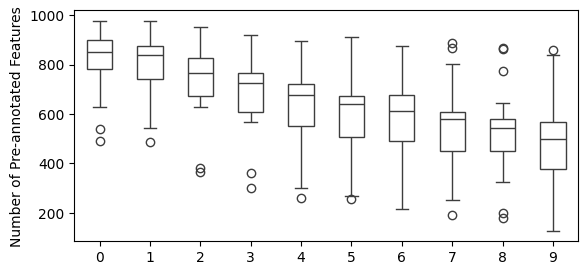

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
boxplot = sns.boxplot(data=bin_counts_poss_all_preannotated, width=0.5, color='w')
ax.set_ylabel('Number of Pre-annotated Features')
plt.savefig(dir_fig_output + 'fig4_boxplot_preannotated_features_orbi_pos.pdf', 
            dpi=300, bbox_inches='tight')

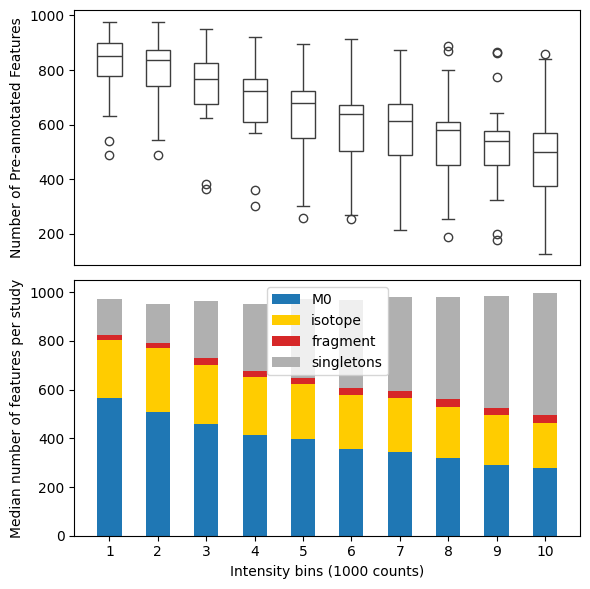

In [79]:
#for type, y in median_bin_counts_pos.items():
#    y = np.array(y)

colors = ['#1f77b4', '#ffcc00', '#d62728', '#b0b0b0'] 
xticks = range(1, 11)
# stacked barplot
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

sns.boxplot(data=bin_counts_poss_all_preannotated, ax=ax[0], width=0.5, color='w')
ax[0].margins(x=0.05)
ax[0].set_xticks([])
ax[0].set_ylabel('Number of Pre-annotated Features')

ax[1].bar(xticks, median_bin_counts_pos['M0'], label='M0', color=colors[0], width=0.5)
ax[1].bar(xticks, median_bin_counts_pos['isotope'], 
        bottom=median_bin_counts_pos['M0'], label='isotope', color=colors[1], width=0.5)
ax[1].bar(xticks, median_bin_counts_pos['fragment'], 
        bottom=np.array(median_bin_counts_pos['M0'])+np.array(median_bin_counts_pos['isotope']), 
        label='fragment', color=colors[2], width=0.5)
ax[1].bar(xticks, median_bin_counts_pos['singletons'], 
        bottom=np.array(median_bin_counts_pos['M0'])+np.array(median_bin_counts_pos['isotope']
                                    )+np.array(median_bin_counts_pos['fragment']), 
        label='singletons', color=colors[3], width=0.5)
ax[1].set_xticks(xticks)
ax[1].set_xlabel('Intensity bins (1000 counts)')
ax[1].set_ylabel('Median number of features per study')
ax[1].legend()
plt.tight_layout()
plt.savefig(dir_fig_output + 'fig4_box_stackedbar_preannotated_features_orbi_pos.pdf', 
            dpi=300, bbox_inches='tight')

In [100]:
bin1_numbers = {}
for x in tally_pos:
    bin1_numbers[x['study']] = len([y for y in x['kilo_matches'] if y==0])

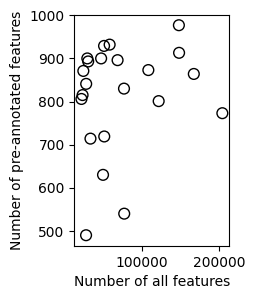

In [95]:
# in top bin, annotated vs number of all features per study
XX, YY = [], []
for x in tally_pos:
    num_preannotated = len([y for y in x['kilo_matches'] if y==0])
    # num_all = x['num_khipus']
    num_all = x['num_features']
    XX.append(num_all)
    YY.append(num_preannotated)

fig, ax = plt.subplots(1, 1, figsize=(2, 3))
ax.scatter(XX, YY, s=60, marker='o', facecolors='none', edgecolors='k')
ax.set_xlabel('Number of all features')
ax.set_ylabel('Number of pre-annotated features')
plt.savefig(dir_fig_output + 'fig4_scatter_preannotated_vs_all_features_orbi_pos.pdf', 
            dpi=300, bbox_inches='tight')

In [108]:
# more comprehensive statistics 
fullstats = pd.read_csv('r1_datasets_stats.tsv', sep='\t', index_col=1)
# fullstats.columns
wanted = ['num_features', 'num_good_features', 'num_empcpds',
       'num_khipus_isopairs', 'num_isopair_mtracks', 'num_good_khipus',
       'num_singletons',  'num_csm_matched']

fullstats.loc['ST001428_HILICpos_B8_ppm5_35204531', 'num_features']

57801

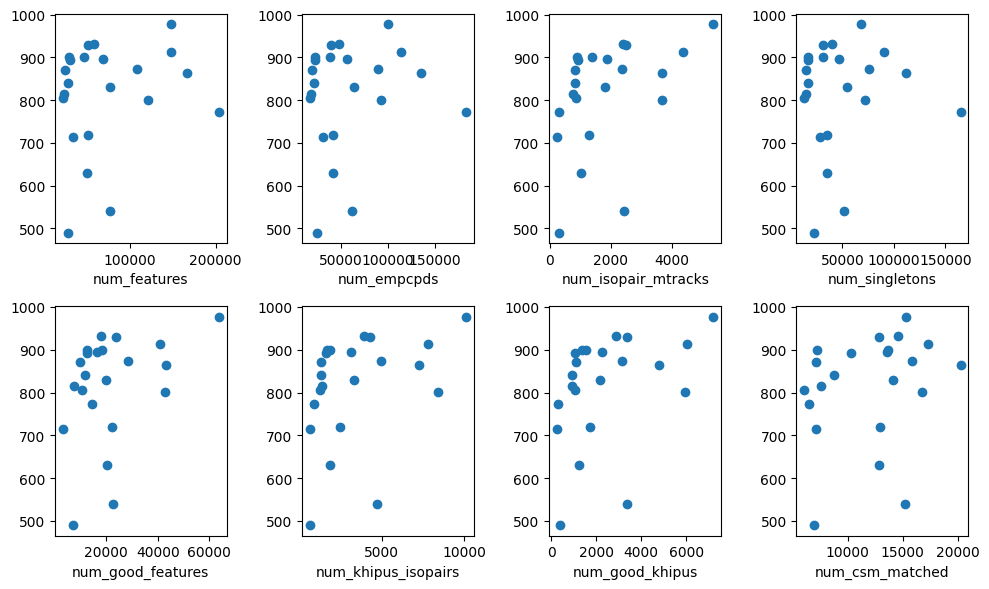

In [112]:
ordered_studies = [x['study'] for x in tally_pos]
YY = [bin1_numbers[x] for x in ordered_studies]

fig, ax = plt.subplots(2, 4, figsize=(10,6))
for ii in range(8):
    ax[ii%2, ii//2].scatter(
        [fullstats.loc[x, wanted[ii]] for x in ordered_studies], YY
    )
    ax[ii%2, ii//2].set_xlabel(wanted[ii])

plt.tight_layout()
plt.savefig(dir_fig_output + 'fig4_scatter_preannotated_vs_stats_orbi_pos.pdf', 
            dpi=300, bbox_inches='tight')

<Axes: title={'center': 'Good Features\nPearson R^2=0.35'}>

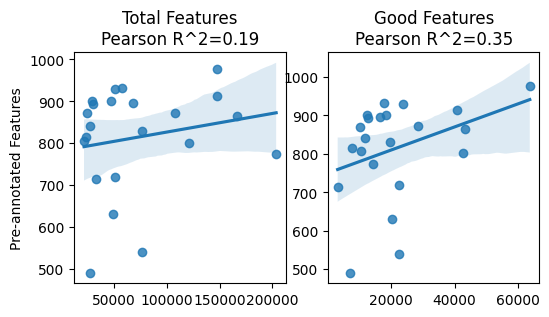

In [117]:
total_features = [fullstats.loc[x, 'num_features'] for x in ordered_studies]
good_features = [fullstats.loc[x, 'num_good_features'] for x in ordered_studies]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
r, p_value = stats.pearsonr(total_features, YY)
ax[0].set_title(f'Total Features\nPearson R^2={r:.2f}')
ax[0].set_ylabel('Pre-annotated Features')
sns.regplot(x=total_features, y=YY, ax=ax[0])
r, p_value = stats.pearsonr(good_features, YY)
ax[1].set_title(f'Good Features\nPearson R^2={r:.2f}')
sns.regplot(x=good_features, y=YY, ax=ax[1])


## preannotated_features unique_empCpds, high-confidence empCpds and HMDB matches


In [18]:
[(k,v) for k,v in tally_pos[0].items() if k != 'kilo_matches']

[('study', 'ST001237_HILICpos_B2_ppm5_3524314'),
 ('num_khipus', 6384),
 ('num_features', 57875),
 ('mzdelta_explained_khipus', 864),
 ('mzdelta_explained_features', 1212),
 ('unique_khipus', 5520),
 ('high_conf_khipus', 2510),
 ('hmdb_matched_high_conf_khipus', 1309)]

5548.0 1338.5 588.5


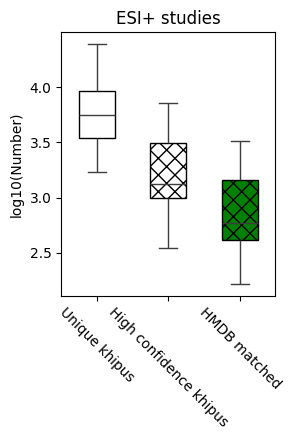

In [40]:
# Fig   unique_khipus
_d = {
    'Unique khipus': np.log10([x['unique_khipus'] for x in tally_pos]),
    'High confidence khipus': np.log10([x['high_conf_khipus'] for x in tally_pos]),
    'HMDB matched': np.log10([x['hmdb_matched_high_conf_khipus'] for x in tally_pos]),
}

print(np.median([x['unique_khipus'] for x in tally_pos]),
      np.median([x['high_conf_khipus'] for x in tally_pos]),
      np.median([x['hmdb_matched_high_conf_khipus'] for x in tally_pos]),
      )

from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(3, 4.5))
boxplot = sns.boxplot(data=_d, width=0.5)
hatches = ['','xx','xx']
colors = ['w', 'w', 'g']
for i, patch in enumerate(boxplot.patches):
    hatch = hatches[i]
    patch.set_hatch(hatch)
    patch.set_edgecolor('black')  # Set border color
    patch.set_facecolor(colors[i])  
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format y-axis with 2 decimal places
ax.set_title("ESI+ studies")
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/v3_Fig4a_preannotation_pos.pdf")

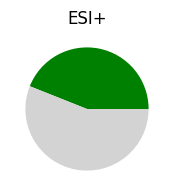

In [42]:
# pie chart of high-confidence khipus
num_hmdb_matched = np.median([x['hmdb_matched_high_conf_khipus'] for x in tally_pos])
num_high_conf_khipus = np.median([x['high_conf_khipus'] for x in tally_pos])
_data = [num_hmdb_matched, 
                     num_high_conf_khipus - num_hmdb_matched,
                    ]
plt.figure(figsize=(2, 2))
plt.pie(_data, colors=['green', 'lightgray'],)
plt.title("ESI+")
plt.savefig(f"{dir_fig_output}/v3_Fig4a_preannotation_pos_pie.pdf")

## Do neg ion studies

In [32]:
neg_candidate_fragments = '''67.9874	762	67.9873	['67.987424', 'NaCOOH', "{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"]
14.0156	614	14.0155	['14.01565', "± CH2, alkane chains, waxes, fatty acids, methylation; or '-[C3H6ON] <-> -[C2H4ON], acrylamide versus iodoacetamide in cysteine alkylation (gels)", "{'C': 1, 'H': 2}"]
2.0156	510	2.0156	['2.01565', '± 2H, opening or forming of double bond', "{'H': 2}"]
82.0029	401	82.0029	['82.0030 C2HF3']
15.9948	371	15.9948	['15.99492', '± O, e.g. oxidation/reduction', "{'O': 1}"]
43.9898	356	43.9897	['43.98983', '± CO2', "{'C': 1, 'O': 2}"]
18.0105	332	18.0104	['-18.010565', 'H2O', "{'H': -2, 'O': -1}"]
26.0156	313	26.0155	[' C2H2']
46.0054	308	46.0053	['-46.005479', 'H2O+CO', "{'C': -1, 'H': -2, 'O': -2}"]
28.0312	299	28.0312	['28.0313', '± C2H4, natural alkane chains such as fatty acids', "{'C': 2, 'H': 4}"]
27.9948	267	27.9948	['27.99492', '± CO', "{'C': 1, 'O': 1}"]
1.9957	255	1.9957	['1.99566', 'F <-> OH, halogen exchange with hydroxy group (typically -F + OH)', "{'F': 1, 'O': -1, 'H': -1}"]
42.0105	229	42.0104	['42.01057', '± COCH2', "{'C': 2, 'O': 1, 'H': 2}"]
'''
neg_isfs = []
for x in neg_candidate_fragments.splitlines():
    pieces = x.split('\t')
    neg_isfs.append((float(pieces[2]), ", ".join(pieces[3].replace("[", "").replace("]", "").split(', ')[1:])))
# neg_isfs
neg_isf_candidate_fragments = [x[0] for x in neg_isfs]
neg_isf_candidate_fragments[:2]

[67.9873, 14.0155]

In [33]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 70 minutes

tally_neg = []
quartile_matches_neg = {}
for study in tqdm.tqdm(neg_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'neg'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_neg, 
                                adduct_search_patterns=adduct_search_patterns_neg,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )

        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, neg_isf_candidate_fragments, 
            rt_stdev=dict_rtwindow[study]
            )

        unique_khipus = [k for k in list_khipus if k['interim_id'] not in explained_khipu_ids]
        high_conf_khipus = [k for k in unique_khipus if 
                            check_isopair_khipu(k)
                            ]
        hmdb_matched = mf.list_match_lcms_features(get_kList(high_conf_khipus), 
                        list_hmdb5, mz_ppm=5, rt_tolerance=1e20)

        dict_intensity_kilos = assign_intensity_kilobins(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        kilo_matches = [dict_intensity_kilos[x] for x in preannotated_feature_ids]

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'unique_khipus': len(unique_khipus),
                'high_conf_khipus': len(high_conf_khipus),
                'hmdb_matched_high_conf_khipus': len(hmdb_matched),
                # 
                'kilo_matches': kilo_matches,
            }
        tally_neg.append(cur_tally)
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        quartile_matches_neg[study] = {
            'M0': [dict_intensity_kilos[x] for x in M0_ids],
            'isotope': [dict_intensity_kilos[x] for x in isotope_ids],
            'fragment': [dict_intensity_kilos[x] for x in fragment_ids],
            'singletons': [dict_intensity_kilos[x] for x in singleton_ids],
        }
        round_id = '20251104_1'
        os.makedirs(f'output/{round_id}/neg/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output/{round_id}/neg/{study}/ecpds.json', 'w'))
        json.dump(cur_tally, open(f'output/{round_id}/neg/{study}/tally.json', 'w'))
        json.dump(quartile_matches_neg[study], open(f'output/{round_id}/neg/{study}/quartile_matches.json', 'w'))

100%|██████████| 23/23 [1:09:06<00:00, 180.27s/it]


In [34]:
for st, v in quartile_matches_neg.items():
    print(st, [len(x) for x in v.values()])

MTBLS2245_HILICneg_Method 4_B5_ppm5_81318755 [4685, 3185, 398, 27228]
ST002937_HILICneg_ST002937_neg_hilic_batch_1_zip_B3_ppm5_353747 [15264, 11518, 860, 75453]
ST002112_HILICneg_B3_ppm5_3552830 [13886, 10481, 934, 69132]
MTBLS1465_HILICneg__ppm5_35195 [4661, 3177, 390, 28133]
MTBLS205_HILICneg__ppm5_353536 [5195, 3309, 407, 22495]
ST002331_RPneg_B5_ppm5_3655219 [2818, 2208, 114, 16989]
MTBLS476_RPneg__ppm5_3551151 [27776, 22561, 1387, 78026]
MTBLS4294_RPneg__ppm5_3542818 [20164, 11288, 1007, 122878]
ST002200_RPneg_5min_B4_ppm5_3423035 [3764, 2679, 523, 11795]
ST001430_RPneg_B4_ppm5_350239 [4935, 3768, 295, 33058]
ST002238_RPneg__ppm5_36104557 [22593, 12665, 1201, 123410]
ST002521_RPneg_B2_ppm5_3673943 [13329, 12140, 928, 45294]
ST002112_RPneg_B2_ppm5_3572946 [23131, 16301, 1344, 77154]
ST001736_RPneg__ppm5_34232652 [5025, 3265, 743, 16393]
ST002554_RPneg__ppm5_3611102 [11192, 8430, 298, 69089]
MTBLS1465_RPneg__ppm5_3514212 [48783, 30235, 1597, 99263]
MTBLS4187_RPneg__ppm5_3524019 [117

In [35]:
bin_counts_negs_all_preannotated = [[]]*10
bin_counts_neg = {'M0': [], 
                      'isotope': [],  
                      'fragment': [],
                      'singletons': []} 
quartile_size = 1000
for type in ['M0', 'isotope', 'fragment', 'singletons']:
    for ii in range(10):
        bin_counts_neg[type].append([
            len([y for y in quartile_matches_neg[x['study']][type] if y==ii]) for x in tally_neg
        ])  
median_bin_counts_neg = {}
for type, list_counts in bin_counts_neg.items():
    median_bin_counts_neg[type] = [np.median(BC) for BC in list_counts] 
for ii in range(10):
    bin_counts_negs_all_preannotated[ii] = [len(
        [y for y in x['kilo_matches'] if y==ii]) for x in tally_neg]
    

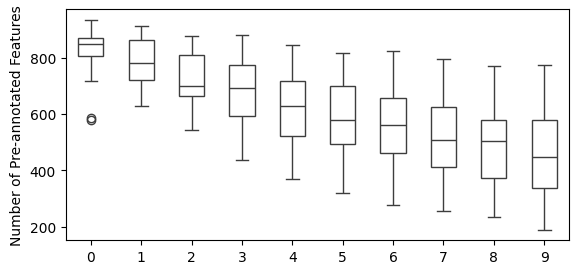

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
boxplot = sns.boxplot(data=bin_counts_negs_all_preannotated, width=0.5, color='w')
ax.set_ylabel('Number of Pre-annotated Features')
plt.savefig(dir_fig_output + 'fig4_boxplot_preannotated_features_orbi_neg.pdf', 
            dpi=300, bbox_inches='tight')

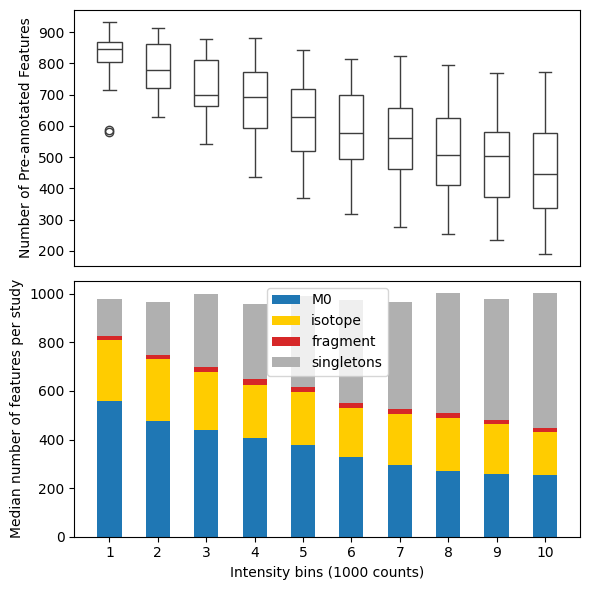

In [38]:
xticks = range(1, 11)
colors = ['#1f77b4', '#ffcc00', '#d62728', '#b0b0b0'] 
# stacked barplot
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

sns.boxplot(data=bin_counts_negs_all_preannotated, ax=ax[0], width=0.5, color='w')
ax[0].margins(x=0.05)
ax[0].set_xticks([])
ax[0].set_ylabel('Number of Pre-annotated Features')
ax[1].bar(xticks, median_bin_counts_neg['M0'], label='M0', color=colors[0], width=0.5)
ax[1].bar(xticks, median_bin_counts_neg['isotope'], 
        bottom=median_bin_counts_neg['M0'], label='isotope', color=colors[1], width=0.5)
ax[1].bar(xticks, median_bin_counts_neg['fragment'], 
        bottom=np.array(median_bin_counts_neg['M0'])+np.array(median_bin_counts_neg['isotope']), 
        label='fragment', color=colors[2], width=0.5)
ax[1].bar(xticks, median_bin_counts_neg['singletons'], 
        bottom=np.array(median_bin_counts_neg['M0'])+np.array(median_bin_counts_neg['isotope']
                                    )+np.array(median_bin_counts_neg['fragment']), 
        label='singletons', color=colors[3], width=0.5)
ax[1].set_xticks(xticks)
ax[1].set_xlabel('Intensity bins (1000 counts)')
ax[1].set_ylabel('Median number of features per study')
ax[1].legend()
plt.tight_layout()
plt.savefig(dir_fig_output + 'fig4_box_stackedbar_preannotated_features_orbi_neg.pdf', 
            dpi=300, bbox_inches='tight')

6060.0 2028.0 934.0


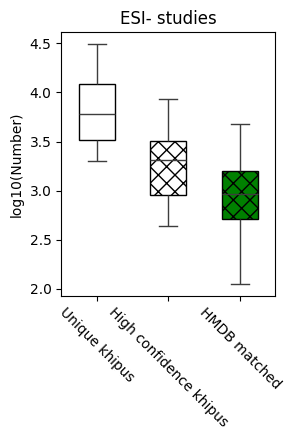

In [41]:
_d = {
    'Unique khipus': np.log10([x['unique_khipus'] for x in tally_neg]),
    'High confidence khipus': np.log10([x['high_conf_khipus'] for x in tally_neg]),
    'HMDB matched': np.log10([x['hmdb_matched_high_conf_khipus'] for x in tally_neg]),
}

print(np.median([x['unique_khipus'] for x in tally_neg]),
      np.median([x['high_conf_khipus'] for x in tally_neg]),
      np.median([x['hmdb_matched_high_conf_khipus'] for x in tally_neg]),
      )

fig, ax = plt.subplots(1, 1, figsize=(3, 4.5))
boxplot = sns.boxplot(data=_d, width=0.5)
hatches = ['','xx','xx']
colors = ['w', 'w', 'g']
for i, patch in enumerate(boxplot.patches):
    hatch = hatches[i]
    patch.set_hatch(hatch)
    patch.set_edgecolor('black')  # Set border color
    patch.set_facecolor(colors[i])  
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format y-axis with 2 decimal places
ax.set_title("ESI- studies")
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/v3_Fig4b_preannotation_neg.pdf")

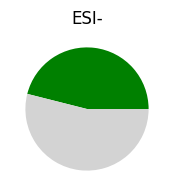

In [43]:
num_hmdb_matched_ = np.median([x['hmdb_matched_high_conf_khipus'] for x in tally_neg])
num_high_conf_khipus_ = np.median([x['high_conf_khipus'] for x in tally_neg])
_data = [num_hmdb_matched_, 
                     num_high_conf_khipus_ - num_hmdb_matched_,
                    ]
plt.figure(figsize=(2, 2))
plt.pie(_data, colors=['green', 'lightgray'],)
plt.title("ESI-")
plt.savefig(f"{dir_fig_output}/v3_Fig4b_preannotation_neg_pie.pdf")

In [44]:
588.5/1338.5, 934/2028

(0.43967127381397086, 0.46055226824457596)

# Conclusion

This notebook plots Figure 5. 

Numbers of pre-annotated features by extended khipus in 45 orbi studies.
a,b. Distribution of numbers of pre-annotated features, median value 16,574 and 16,296 for positive and negative ionization datasets, respectively. They correspond to 5,539 and 5,937 unique khipus, respectively.

 c,d. Percentage distribution of pre-annotated features in each intensity quartile in each study, for positive and negative ionization datasets, respectively. The pie charts show mean percentage in each quartile, respectively. 